In [1]:
# this file is making live predictions if a sample is of an OCD activity or not

%load_ext autoreload
%autoreload 2

from sklearn.preprocessing import StandardScaler
from tsfresh import select_features
from tsfresh.feature_extraction import MinimalFCParameters, EfficientFCParameters
from tsfresh.utilities.dataframe_functions import impute

from classification.classification import train_and_select_best_model, predict
from data_reading.phyphox import read_experiments_in_dir
from features import extract_timeseries_features
from file_handling import get_sub_directories
from preprocessing import segment_for_null_classification, segment_windows, concat_chunks_for_feature_extraction, \
    preprocess_chunks_for_null_test
from shared_constants import SEGMENTATION_NO_OVERLAP, SEGMENTATION_OVERLAP

sample_rate = 50

experiment_dir_path = "../../data/phyphox/full recordings/"
experiment_dirs = get_sub_directories(experiment_dir_path)
use_indoor = True
use_fingerprinting_approach = True
window_size = 100
feature_calculation_setting = MinimalFCParameters()

experiment_dirs_selected = ["Ana-2","Anne2", "Anne3", "Marvin","Ariane","Cilly","Fabi","Jonas","Julian","Julius","Wiktoria"]
experiment_dirs = [exp_dir for exp_dir in experiment_dirs if exp_dir.split("/")[-1] in experiment_dirs_selected]

#selected_activities = ["washing hands", "drying hands"]
selected_activities = ["pulling door", "pushing door"]

# Read data
chunks, null_chunks, y = read_experiments_in_dir(experiment_dirs, sample_rate, drop_lin_acc=True,
                                                 require_indoor=use_indoor, selected_activities=selected_activities)

del experiment_dirs
print("Finished reading data")


Bad key "text.kerning_factor" on line 4 in
/Users/julio/opt/anaconda3/envs/master-project/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution
/Users/julio/Documents/Uni/5_Master/Master Project/mp-mental-health-2020/src/preprocessing/_data_frame.py:31: FutureWarning: Passing datetime64-dtype data to TimedeltaIndex is deprecated, will raise a TypeError in a future version
  time_delta_index = pd.TimedeltaIndex(timestamp_to_date, unit=output_timestamp_unit)
/Users/julio/opt/anaconda3/envs/master-project/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

Finished reading data


In [2]:
chunks_ocd, chunks_null_class = preprocess_chunks_for_null_test(chunks, null_chunks, use_indoor=use_indoor)
#labels = y_ocd.loc[:, "label"].squeeze()
#assert len(labels) == len(chunks_ocd)
del chunks
del null_chunks
chunks_ocd_segmented, labels_ocd_segmented, chunks_null_segmented, labels_null_segmented = segment_for_null_classification(chunks_ocd, chunks_null_class, window_size)

assert len(set(labels_ocd_segmented)) == 1
assert len(set(labels_null_segmented)) == 1

null_classification_df, labels_null_classification = concat_chunks_for_feature_extraction(
        [chunks_ocd_segmented, chunks_null_segmented],
        [labels_ocd_segmented, labels_null_segmented])
assert len(set(labels_null_classification)) == 2

/Users/julio/Documents/Uni/5_Master/Master Project/mp-mental-health-2020/src/preprocessing/_segmentation.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_new["combined_id"] = [(action_id, i)] * len(c_new)
/Users/julio/Documents/Uni/5_Master/Master Project/mp-mental-health-2020/src/preprocessing/_segmentation.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_new["action_id"] = [action_id] * len(c_new)
/Users/julio/Documents/Uni/5_Master/Master Project/mp-mental-health-2020/src/preprocessing/_segment

In [5]:
X_null_class_classification = extract_timeseries_features(null_classification_df, use_indoor=use_indoor,
                                                              feature_set_config=feature_calculation_setting,
                                                              use_fingerprinting_approach=use_fingerprinting_approach)
impute(X_null_class_classification)
X_null_classification_selected = select_features(X_null_class_classification, labels_null_classification)

# store the features so that we can apply the same feature selection later on the test data
selected_features = X_null_classification_selected.columns
selected_features

Feature Extraction: 100%|██████████| 20/20 [00:10<00:00,  1.82it/s]


Index([                 'acceleration y__minimum',
                         'acceleration y__median',
                     'acceleration y__sum_values',
                           'acceleration y__mean',
                        'acceleration y__maximum',
                           'acceleration x__mean',
                     'acceleration x__sum_values',
                         'acceleration x__median',
               'acceleration y_right__sum_values',
                     'acceleration y_right__mean',
                        'acceleration x__minimum',
                   'acceleration y_right__median',
                        'acceleration z__maximum',
                  'acceleration y_right__maximum',
                                                6,
                  'acceleration y_right__minimum',
                        'acceleration x__maximum',
                                                5,
                         'acceleration z__median',
                           'acc

In [6]:
scaler = StandardScaler()
X_null_classification_scaled = scaler.fit_transform(X_null_classification_selected)

In [5]:
trained_model = train_and_select_best_model(X_null_classification_scaled, labels_null_classification)

Training model
Best scoring model LDA has average f score of 0.88


In [6]:
# test on long recording

test_data_dir = experiment_dir_path + "Anne/"
chunks_test, null_chunks_test, y_test = read_experiments_in_dir([test_data_dir], sample_rate, drop_lin_acc=True,
                                                 require_indoor=use_indoor)

chunks_ocd_test, chunks_null_class_test = preprocess_chunks_for_null_test(chunks_test, null_chunks_test, use_indoor=use_indoor)

# we need to zip the chunks back
chunks_test_all = list(sum(zip(chunks_ocd_test, chunks_null_class_test),())) # we might need to append the last element from the chunks_test at the end as well

chunks_test_segmented, labels_test_segmented = segment_windows(chunks_test_all, ["Test"] * len(chunks_test_all), window_size, SEGMENTATION_NO_OVERLAP)
#chunks_test_segmented = [chunks_test_all[] ]

/Users/julio/Documents/Uni/5_Master/Master Project/mp-mental-health-2020/src/preprocessing/_data_frame.py:31: FutureWarning: Passing datetime64-dtype data to TimedeltaIndex is deprecated, will raise a TypeError in a future version
  time_delta_index = pd.TimedeltaIndex(timestamp_to_date, unit=output_timestamp_unit)
/Users/julio/opt/anaconda3/envs/master-project/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/julio/Documents/Uni/5_Master/Master Project/mp-mental-health-2020/src/preprocessing/_segmentation.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-doc

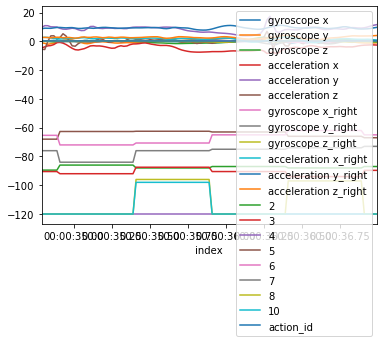

In [7]:
chunks_test_all[0].plot(kind="line")

In [8]:
print(len(chunks_test_all))
print(y_test[y_test["label"] == "checking oven"])
#print(y_test[y_test["label"] == "pulling door"])

156
    index  start    end          label   hand
12     12   89.9   99.3  checking oven  right
13     13  102.9  109.0  checking oven  right
14     14  113.5  120.4  checking oven  right
15     15  123.7  130.2  checking oven  right
16     16  133.5  137.6  checking oven  right


In [ ]:
import pandas as pd
# split into blocks of 10 chunks for which we want to predict
block_size = 10
segment_id = 0
blocks = [chunks_test_segmented[i*block_size:(i+1)*block_size] for i in range(int(len(chunks_test_segmented)/block_size))]
for b in blocks:
    current_df, _ = concat_chunks_for_feature_extraction(chunks=[b], labels=[pd.Series(["Test"] * block_size)]) # the labels don't matter
    X_test = extract_timeseries_features(current_df, use_indoor=use_indoor,
                                                              feature_set_config=feature_calculation_setting,
                                                              use_fingerprinting_approach=use_fingerprinting_approach)
    #print(X_test.iloc[:10])
    impute(X_test)
    X_test = X_test.loc[:, list(selected_features)]
    X_test_scaled = scaler.transform(X_test)
    predictions = predict(X=X_test_scaled, model=trained_model)
    for i in range(block_size):
        binary_pred = 1 if predictions[i] == "OCD activity" else 0
        print("{},{}".format(b[i].reset_index()["index"][0].total_seconds(), binary_pred))
        #print("Action: {}: start time: {}: {}".format(b[i]["action_id"][0], b[i].reset_index()["index"][0].total_seconds(), predictions[i]))
    del X_test
    del X_test_scaled
    del current_df



Feature Extraction:   0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
len(blocks[0])
